In [1]:
import numpy as np
import torch

from torch_geometric.utils import to_networkx
from torch_geometric.datasets import AMiner
from torch_geometric.nn import MetaPath2Vec

## Simple example of MetaPath2Vec

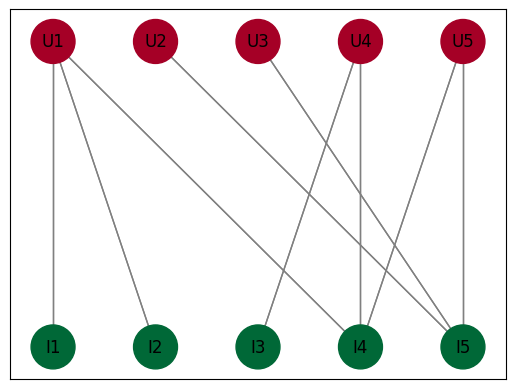

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data['user', 'item'].edge_index = torch.tensor([
    [0, 0, 0, 1, 2, 3, 3, 4, 4], [0, 1, 3, 4, 4, 2, 3, 3, 4]
])
data['user'].num_nodes = 5
data['item'].num_nodes = 5
data = T.ToUndirected()(data)

users_labels_mapping = {i: f'U{i+1}' for i in range(data['user'].num_nodes)}
items_labels_mapping = {i + data['user'].num_nodes: f'I{i+1}' for i in range(data['item'].num_nodes)}
labels_mapping = dict(users_labels_mapping)
labels_mapping.update(items_labels_mapping)

graph = to_networkx(data)
nx.draw_networkx(
    graph,
    pos=nx.bipartite_layout(graph, nodes=np.arange(5, 10), align='horizontal'),
    node_color=np.r_[np.ones(5)*0.4, np.ones(5)*0.6],
    cmap='RdYlGn',
    node_size=1000,
    edge_color='grey',
    arrows=False,
    labels=labels_mapping
    )

In [3]:
data

HeteroData(
  user={ num_nodes=5 },
  item={ num_nodes=5 },
  (user, to, item)={ edge_index=[2, 9] },
  (item, rev_to, user)={ edge_index=[2, 9] }
)

In [15]:
metapath = [
    ('user', 'to', 'item'),
    ('item', 'rev_to', 'user'),
]

mp2v = MetaPath2Vec(data.edge_index_dict, embedding_dim=2, walks_per_node=2,
                     metapath=metapath, walk_length=3, context_size=3)
loader = mp2v.loader(batch_size=1)
optimizer = torch.optim.Adam(list(mp2v.parameters()), lr=0.01)

In [16]:
for pos_rw, neg_rw in loader:
    print(f'{pos_rw[:5,:]=}')
    print(f'{neg_rw[:5,:]=}')
    break

pos_rw[:5,:]=tensor([[5, 0, 5],
        [5, 1, 5],
        [0, 5, 0],
        [1, 5, 3]])
neg_rw[:5,:]=tensor([[5, 1, 7],
        [5, 4, 6],
        [1, 7, 3],
        [4, 6, 4]])


In [23]:
def train(epoch):
    mp2v.train()
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = mp2v.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()

        print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                f'Loss: {loss :.4f}'))

for epoch in range(1, 100):
    train(epoch)

Epoch: 1, Step: 00001/5, Loss: 0.8972
Epoch: 1, Step: 00002/5, Loss: 0.9822
Epoch: 1, Step: 00003/5, Loss: 1.0309
Epoch: 1, Step: 00004/5, Loss: 1.2421
Epoch: 1, Step: 00005/5, Loss: 0.8492
Epoch: 2, Step: 00001/5, Loss: 1.4764
Epoch: 2, Step: 00002/5, Loss: 0.8099
Epoch: 2, Step: 00003/5, Loss: 0.9149
Epoch: 2, Step: 00004/5, Loss: 1.1095
Epoch: 2, Step: 00005/5, Loss: 1.0232
Epoch: 3, Step: 00001/5, Loss: 1.2623
Epoch: 3, Step: 00002/5, Loss: 1.6531
Epoch: 3, Step: 00003/5, Loss: 1.1720
Epoch: 3, Step: 00004/5, Loss: 1.3268
Epoch: 3, Step: 00005/5, Loss: 1.2440
Epoch: 4, Step: 00001/5, Loss: 1.2979
Epoch: 4, Step: 00002/5, Loss: 0.9208
Epoch: 4, Step: 00003/5, Loss: 1.2038
Epoch: 4, Step: 00004/5, Loss: 0.9144
Epoch: 4, Step: 00005/5, Loss: 1.1887
Epoch: 5, Step: 00001/5, Loss: 1.2369
Epoch: 5, Step: 00002/5, Loss: 0.8647
Epoch: 5, Step: 00003/5, Loss: 1.2848
Epoch: 5, Step: 00004/5, Loss: 1.2385
Epoch: 5, Step: 00005/5, Loss: 1.1107
Epoch: 6, Step: 00001/5, Loss: 0.8270
Epoch: 6, St

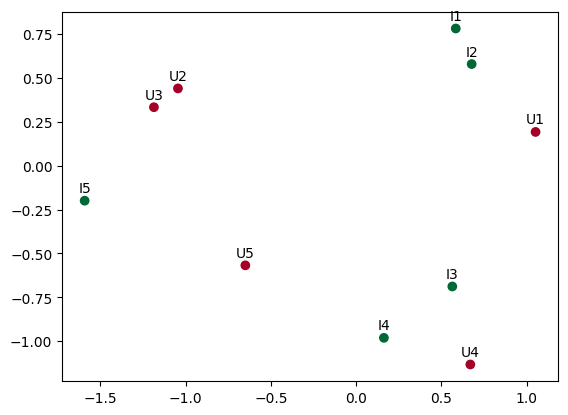

In [24]:
users_emb = mp2v.forward('user').detach().numpy()
items_emb = mp2v.forward('item').detach().numpy()

x_embs = np.r_[users_emb[:, 0], items_emb[:, 0]]
y_embs = np.r_[users_emb[:, 1], items_emb[:, 1]]
nodes_color = np.r_[np.ones(data['user'].num_nodes)*0.4, np.ones(data['item'].num_nodes)*0.6]

plt.scatter(x=x_embs,
            y=y_embs,
            c=nodes_color,
            cmap='RdYlGn')

for i, (x, y) in enumerate(zip(x_embs, y_embs)):
    plt.text(x, y+0.03, labels_mapping[i], va='bottom', ha='center')

## Example on AMiner dataset

In [13]:
data = AMiner('../data/AMiner')[0]

In [14]:
data

HeteroData(
  author={
    y=[246678],
    y_index=[246678],
    num_nodes=1693531,
  },
  venue={
    y=[134],
    y_index=[134],
    num_nodes=3883,
  },
  paper={ num_nodes=3194405 },
  (paper, written_by, author)={ edge_index=[2, 9323605] },
  (author, writes, paper)={ edge_index=[2, 9323605] },
  (paper, published_in, venue)={ edge_index=[2, 3194405] },
  (venue, publishes, paper)={ edge_index=[2, 3194405] }
)

In [4]:
metapath = [
    ('author', 'writes', 'paper'),
    ('paper', 'published_in', 'venue'),
    ('venue', 'publishes', 'paper'),
    ('paper', 'written_by', 'author'),
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
mp2v = MetaPath2Vec(data.edge_index_dict, embedding_dim=128,
                     metapath=metapath, walk_length=30, context_size=5,
                     walks_per_node=4, num_negative_samples=4,
                     sparse=True).to(device)

loader = mp2v.loader(batch_size=32, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(mp2v.parameters()), lr=0.01)

In [5]:
def train(epoch, log_steps=100, eval_steps=2000):
    
    mp2v.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = mp2v.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))


@torch.no_grad()
def test(train_ratio=0.1):
    mp2v.eval()

    z = mp2v('author', batch=data['author'].y_index.to(device))
    y = data['author'].y

    perm = torch.randperm(z.size(0))
    train_perm = perm[:int(z.size(0) * train_ratio)]
    test_perm = perm[int(z.size(0) * train_ratio):]

    return mp2v.test(z[train_perm], y[train_perm], z[test_perm], y[test_perm],
                      max_iter=150)

In [6]:
for epoch in range(1, 6):
    train(epoch)
    acc = test()
    print(f'Epoch: {epoch}, Accuracy: {acc:.4f}')

Epoch: 1, Step: 00100/52923, Loss: 9.6176
Epoch: 1, Step: 00200/52923, Loss: 9.0892
Epoch: 1, Step: 00300/52923, Loss: 8.5782
Epoch: 1, Step: 00400/52923, Loss: 8.0990
Epoch: 1, Step: 00500/52923, Loss: 7.6909
Epoch: 1, Step: 00600/52923, Loss: 7.3222
Epoch: 1, Step: 00700/52923, Loss: 7.0258
Epoch: 1, Step: 00800/52923, Loss: 6.7638
Epoch: 1, Step: 00900/52923, Loss: 6.5626
Epoch: 1, Step: 01000/52923, Loss: 6.3836
Epoch: 1, Step: 01100/52923, Loss: 6.2565
Epoch: 1, Step: 01200/52923, Loss: 6.1658
Epoch: 1, Step: 01300/52923, Loss: 6.0762
Epoch: 1, Step: 01400/52923, Loss: 6.0316
Epoch: 1, Step: 01500/52923, Loss: 5.9838
Epoch: 1, Step: 01600/52923, Loss: 5.9674
Epoch: 1, Step: 01700/52923, Loss: 5.9307
Epoch: 1, Step: 01800/52923, Loss: 5.9107
Epoch: 1, Step: 01900/52923, Loss: 5.8901
Epoch: 1, Step: 02000/52923, Loss: 5.8706
Epoch: 1, Step: 02000/52923, Acc: 0.2753
Epoch: 1, Step: 02100/52923, Loss: 5.8483
Epoch: 1, Step: 02200/52923, Loss: 5.8368
Epoch: 1, Step: 02300/52923, Loss: 

KeyboardInterrupt: 

: 